In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anatools.data as data
import anatools.analysis as ana

import btaggingeffmaps as btef

ana.start()

# Read datasets grouped files and merge DY datasets

In [2]:
period = '16'
basedir = '/cernbox/masters_research/HHDM/btaggingEffMaps'
datasets = data.read_files(basedir, period)

DY = [
    datasets["DYJetsToLL_Pt-Inclusive"],
    datasets["DYJetsToLL_Pt-50To100"],
    datasets["DYJetsToLL_Pt-100To250"],
    datasets["DYJetsToLL_Pt-250To400"],
    datasets["DYJetsToLL_Pt-400To650"],
    datasets["DYJetsToLL_Pt-650ToInf"],
]

datasets["DYJetsToLL"] = pd.concat(DY).reset_index(drop=True)

del datasets["DYJetsToLL_Pt-Inclusive"]
del datasets["DYJetsToLL_Pt-50To100"]
del datasets["DYJetsToLL_Pt-100To250"]
del datasets["DYJetsToLL_Pt-250To400"]
del datasets["DYJetsToLL_Pt-400To650"]
del datasets["DYJetsToLL_Pt-650ToInf"]

100%|██████████| 28/28 [00:14<00:00,  1.87it/s]


# Check number of events in each dataset after cut in pt

* We can define pt_max for efficiency map sweeping if for all datasets analyzed the number of events after pt_max cut is lesser than 0.1%

In [3]:
pt_max = 1500.

for dataset_name in datasets.keys():
    df_alljets = datasets.get(dataset_name).reset_index(drop=True)
    n_total = df_alljets.evtWeight.sum()
    n_above_cut = df_alljets[df_alljets.Jet_pt > pt_max].evtWeight.sum()
    quant = "{:.1f}%".format(100*n_above_cut/n_total)
    print(dataset_name, '->', quant)

Signal_800_200 -> 0.0%
Signal_400_100 -> 0.0%
ST_t-channel_antitop -> 0.0%
ZGToLLG -> 0.0%
Signal_600_200 -> 0.0%
ZZZ -> 0.0%
ZZ -> 0.0%
ST_t-channel_top -> 0.0%
WW -> 0.0%
Signal_600_400 -> 0.0%
Signal_1000_300 -> 0.0%
TTGJets -> 0.0%
TTToSemiLeptonic -> 0.0%
TTTo2L2Nu -> 0.0%
ST_tW_antitop -> 0.0%
ST_tW_top -> 0.0%
WZ -> 0.0%
WWW -> 0.0%
WWZ -> 0.0%
Signal_800_400 -> 0.0%
WZZ -> 0.0%
TTGamma -> 0.0%
DYJetsToLL -> 0.0%


# Compute efficiency maps for all datasets

In [4]:
def makeBtaggingEffMaps(meta):

    dataset_name = meta.get('dataset_name')
    max_unc = meta.get('max_unc')
    eta_bins = meta.get('eta_bins')
    year = meta.get('year')
    algo = meta.get('algo')
    working_point = meta.get('working_point')
    pt_min = meta.get('pt_min')
    pt_max = meta.get('pt_max')
    step_size = meta.get('step_size')

    df = datasets.get(dataset_name).reset_index(drop=True)
    mmap = btef.BTaggingEfficiencyMap(df, eta_bins)
    mmap.calib(year, algo, working_point)
    eff_map = mmap.make(pt_min, pt_max, step_size, max_unc)

    return (dataset_name, eff_map)

year = '2016'
algo = 'DeepCSV'
working_point = 'loose'
eta_bins = [0., 0.6, 1.2, 2.4]
pt_min = 20.
step_size = 5.

if year == '2016':
    yc = '2016postVFP'
else:
    yc = year

uncmap_fpath = f'./output/btaguncmap-{algo}-{working_point}-{yc}.json'
if os.path.exists(uncmap_fpath) is False:
    accepted_unc = {
        dataset_name: {
            "b": 0.001,
            "c": 0.001,
            "udsg": 0.001
        }
        for dataset_name in datasets.keys()
    }
else:
    with open(uncmap_fpath, 'r') as f:
        accepted_unc = json.load(f)

job_metadata = []

for dataset_name in datasets.keys():
    job_metadata.append({
        'dataset_name': dataset_name,
        'max_unc': accepted_unc.get(dataset_name),
        'eta_bins': eta_bins,
        'year': year,
        'algo': algo,
        'working_point': working_point,
        'pt_min': pt_min,
        'pt_max': pt_max,
        'step_size': step_size,
    })

results = [makeBtaggingEffMaps(meta) for meta in job_metadata]

eff_maps = dict([(res[0], res[1][0]) for res in results])
unc_maps = dict([(res[0], res[1][1]) for res in results])

json_fname = f'btageffmap-{algo}-{working_point}-{yc}.json'
json_fpath = os.path.join('./output', json_fname)
with open(json_fpath, 'w') as f:
    json.dump(eff_maps, f)

json_fname = f'btaguncmap-{algo}-{working_point}-{yc}.json'
json_fpath = os.path.join('./output', json_fname)
with open(json_fpath, 'w') as f:
    json.dump(unc_maps, f, indent=4, ensure_ascii=False)

/workspace/btageffanalyzer/__init__.py:76: RuntimeWarning: invalid value encountered in true_divide
  unc = np.sqrt(hist_tag2) / hist_tag


# Efficiency per eta bin

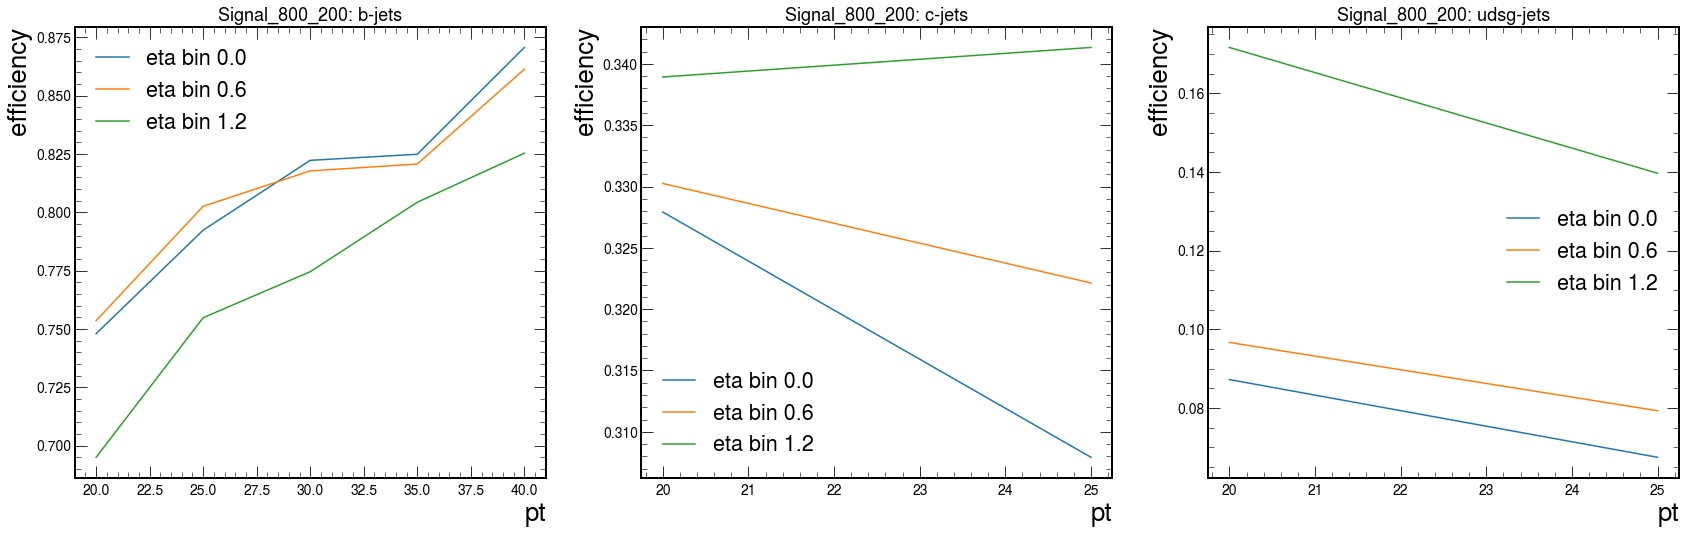

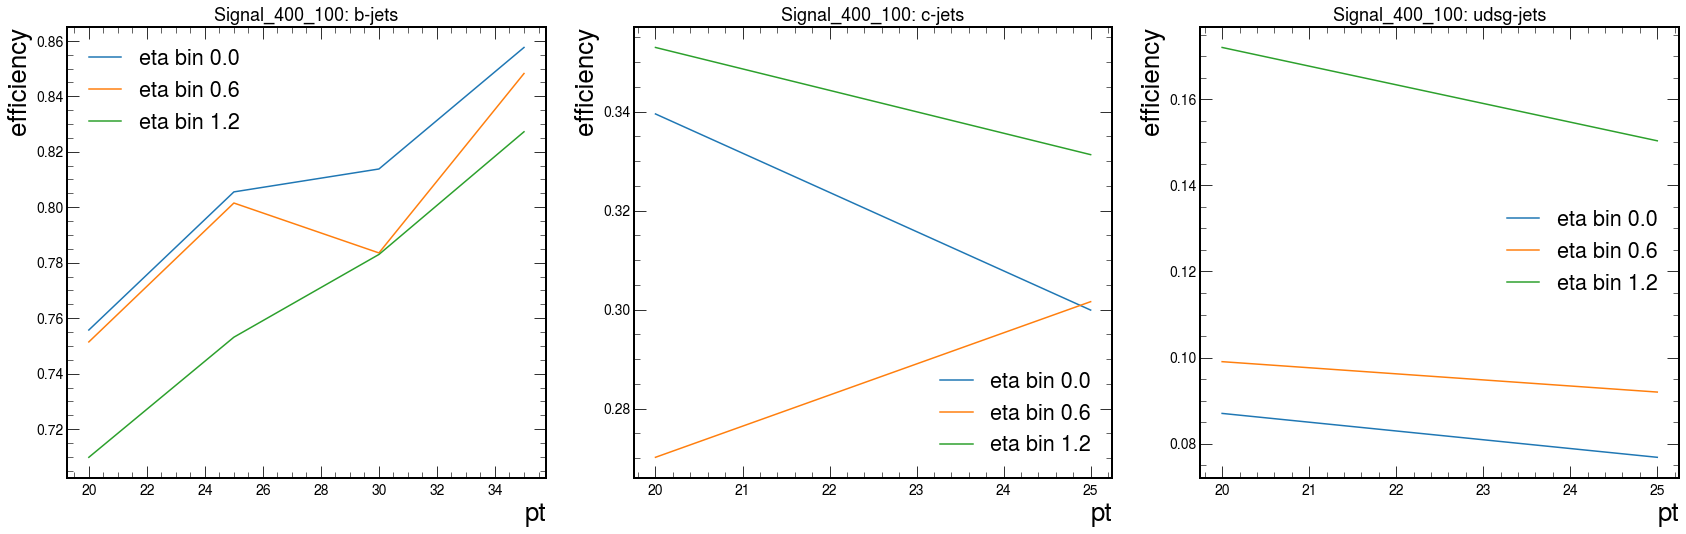

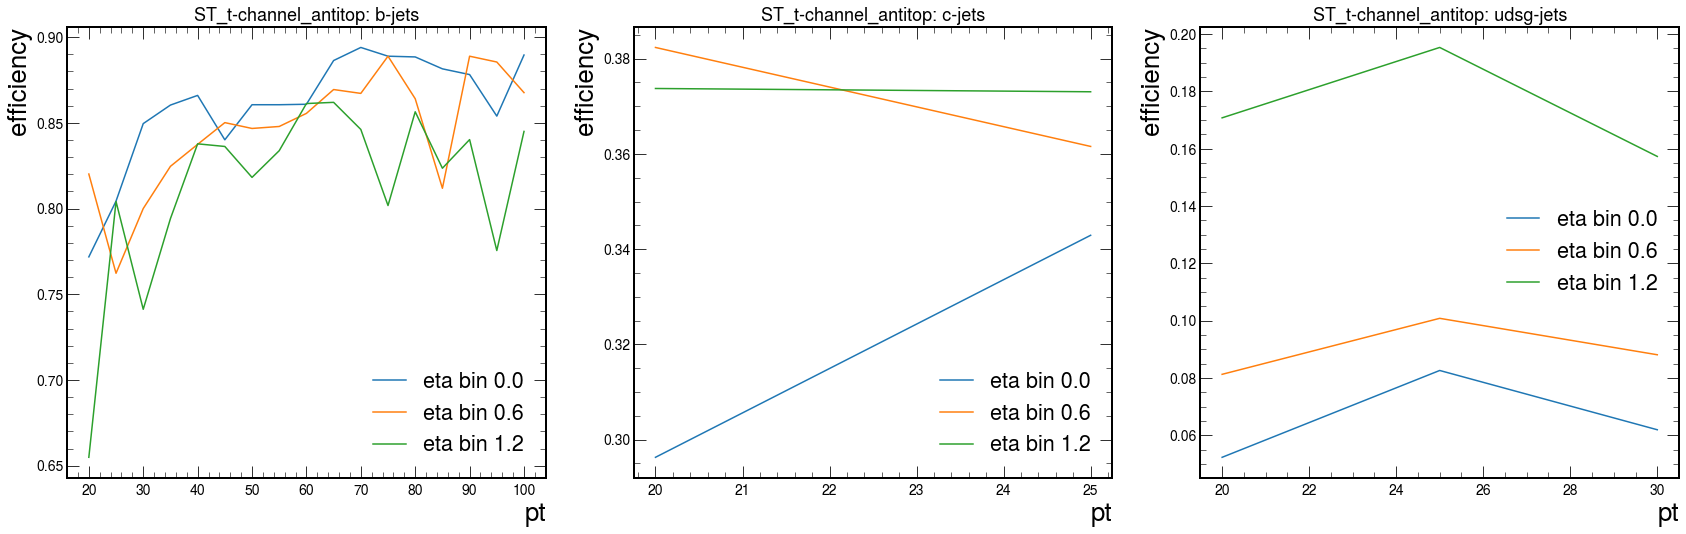

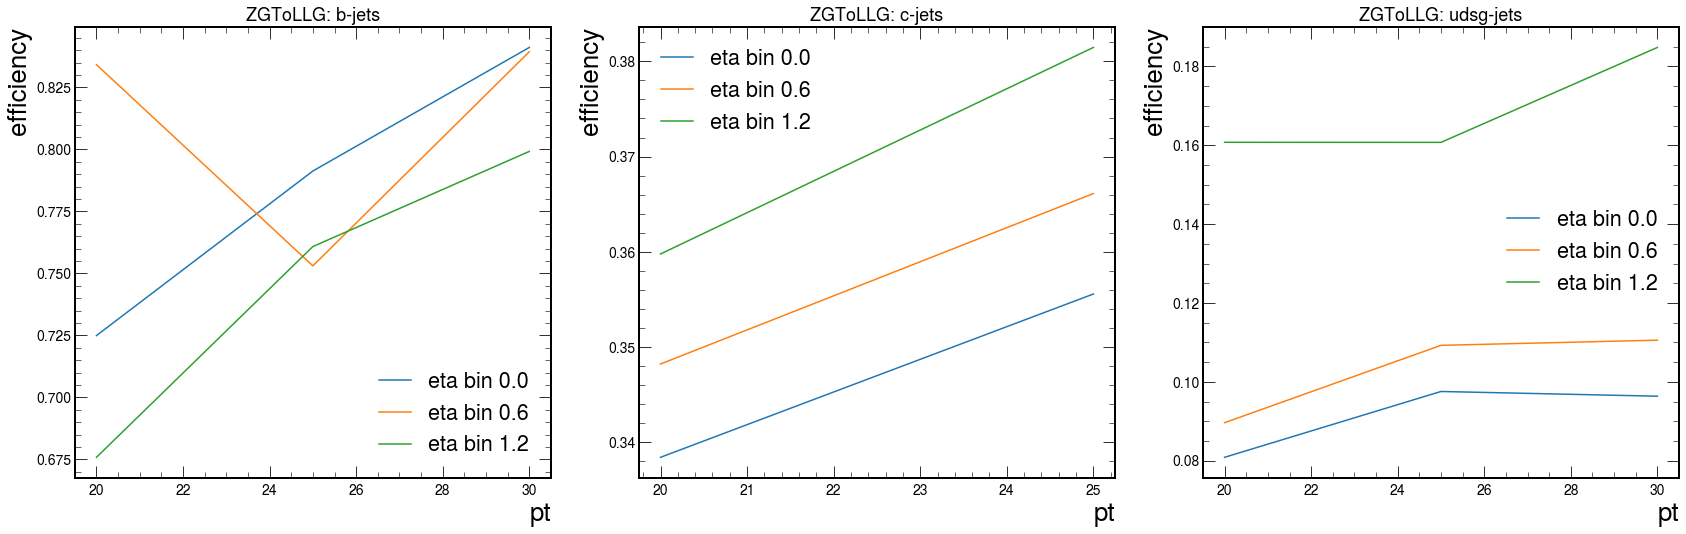

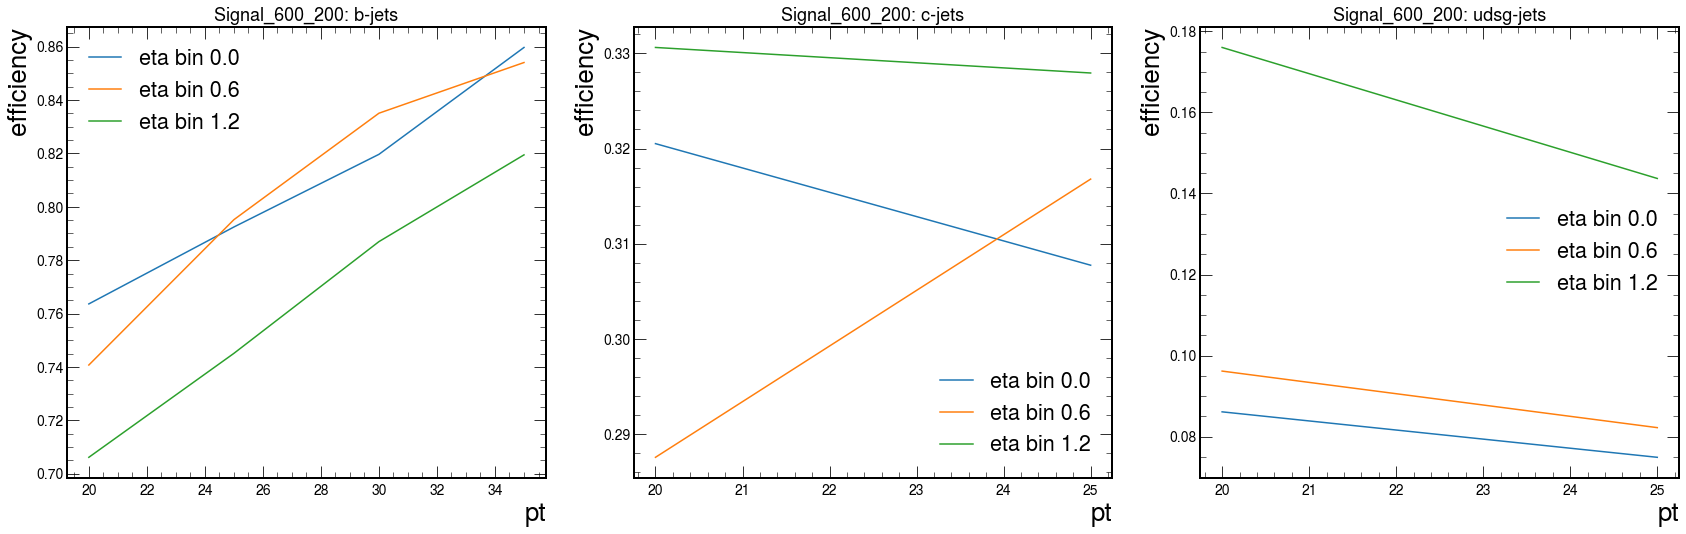

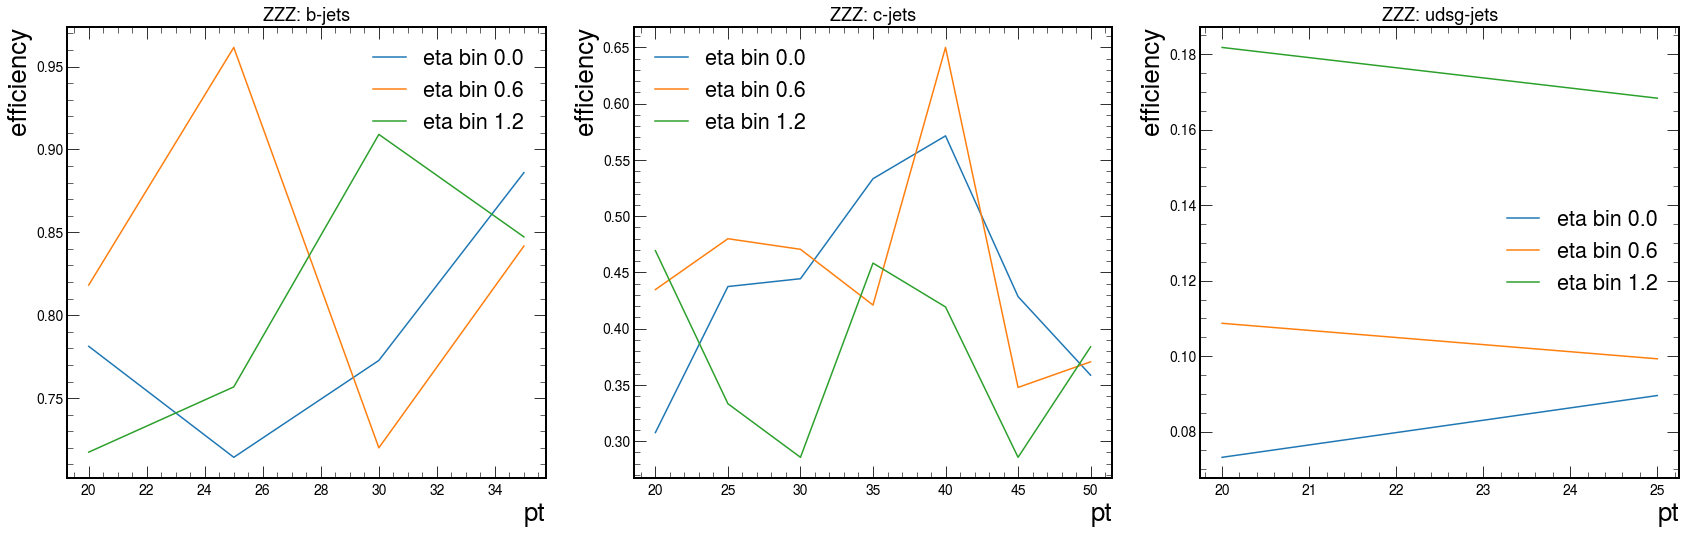

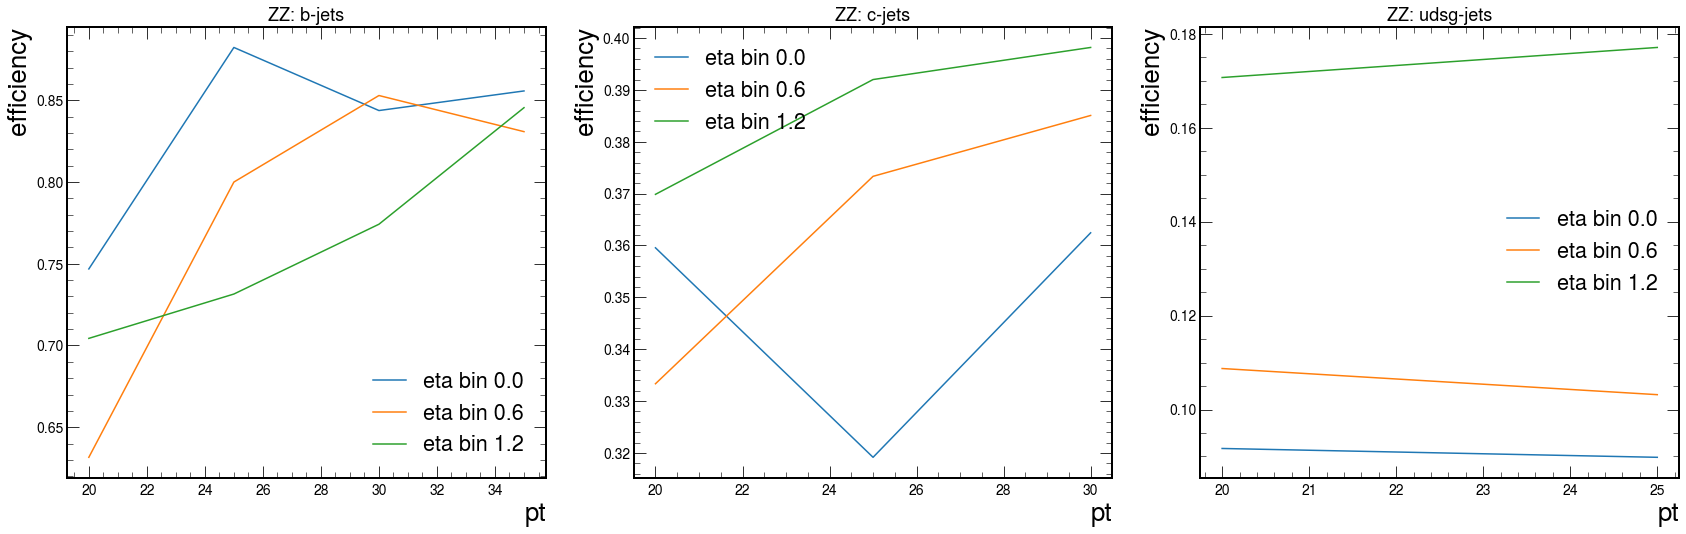

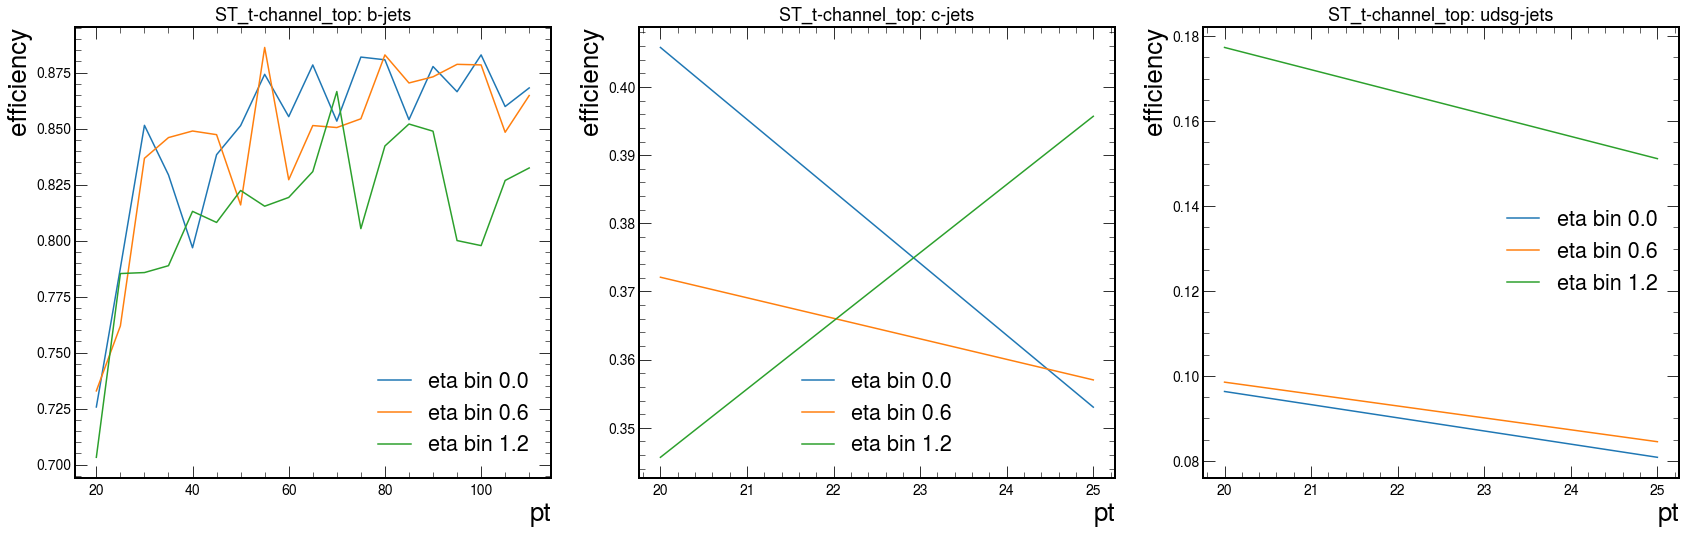

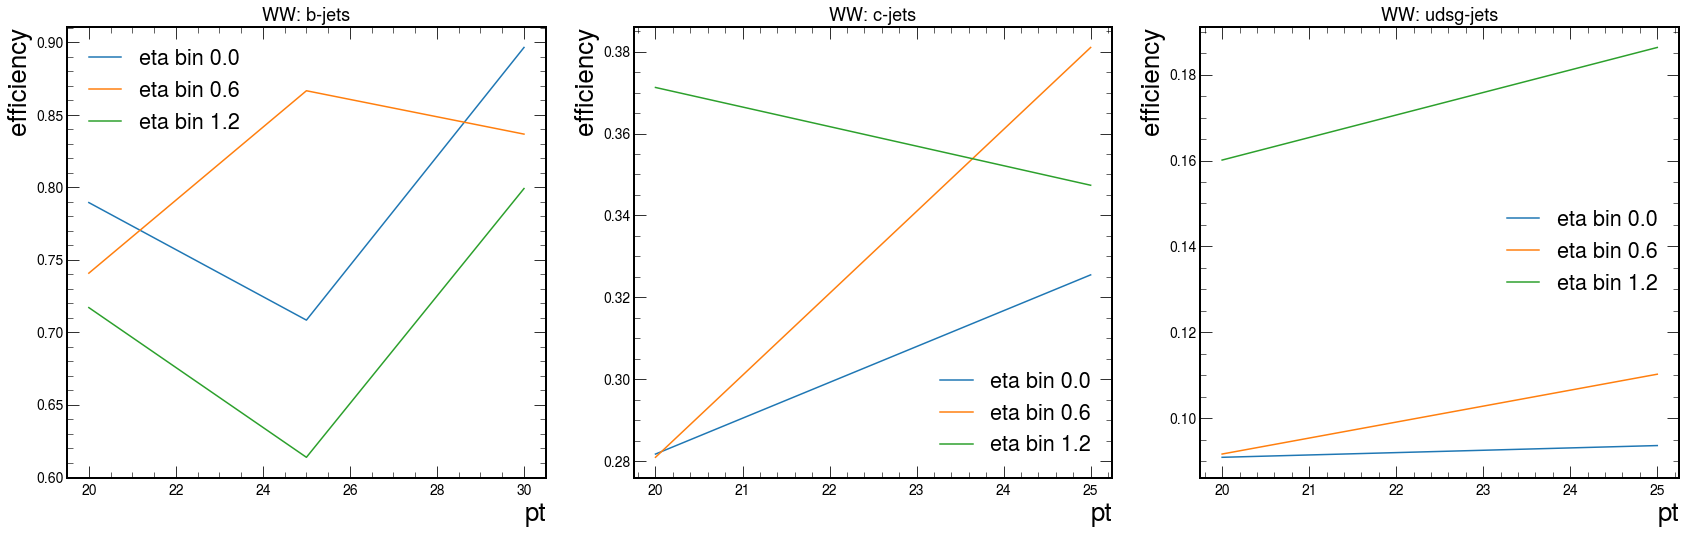

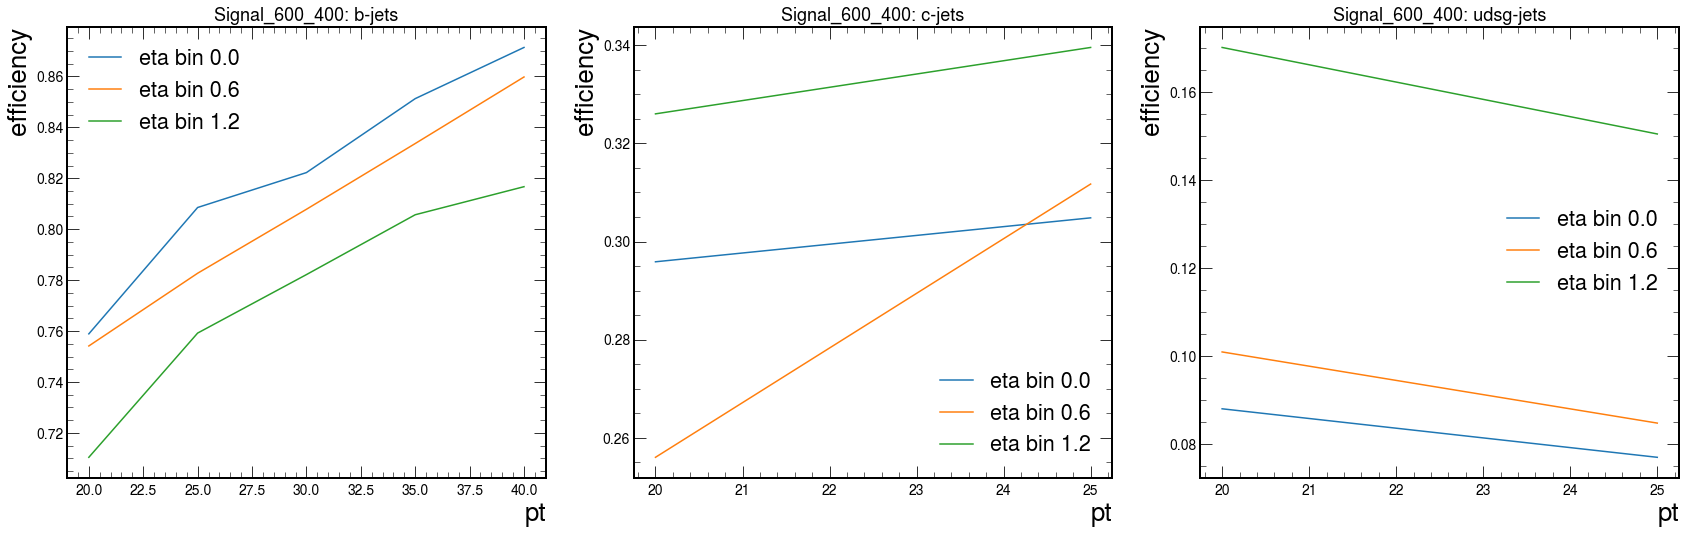

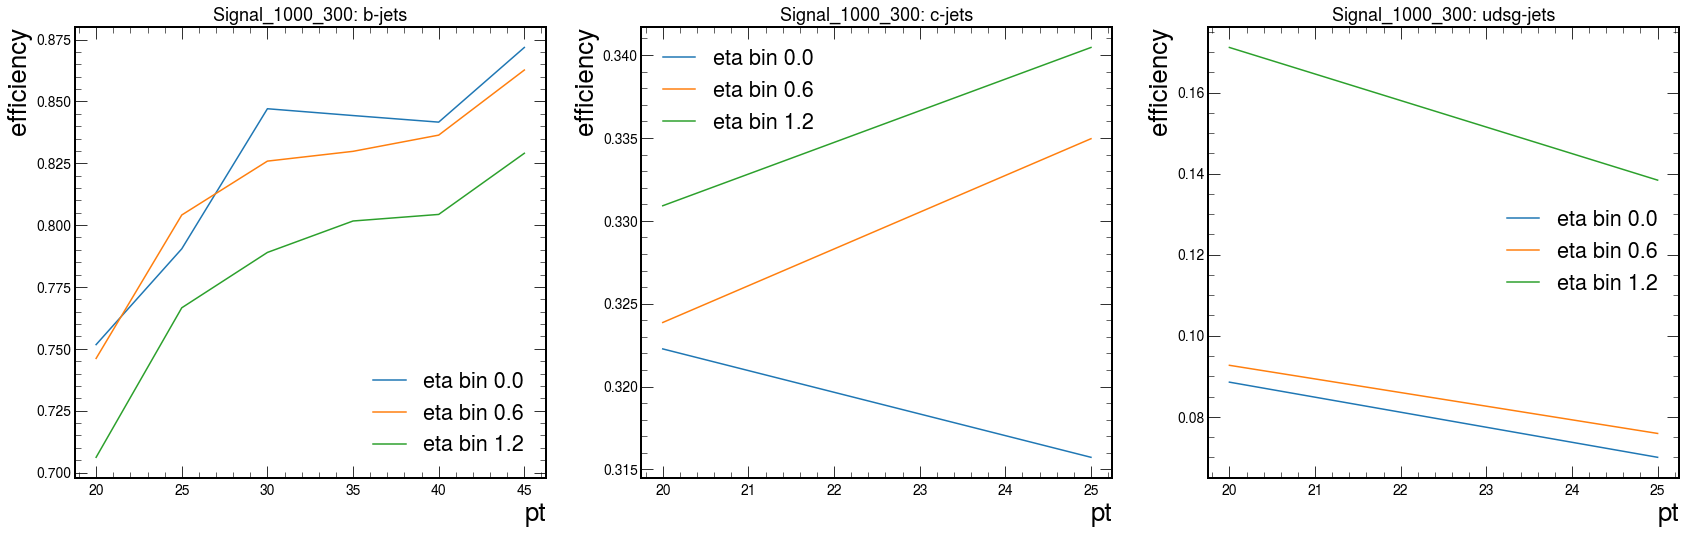

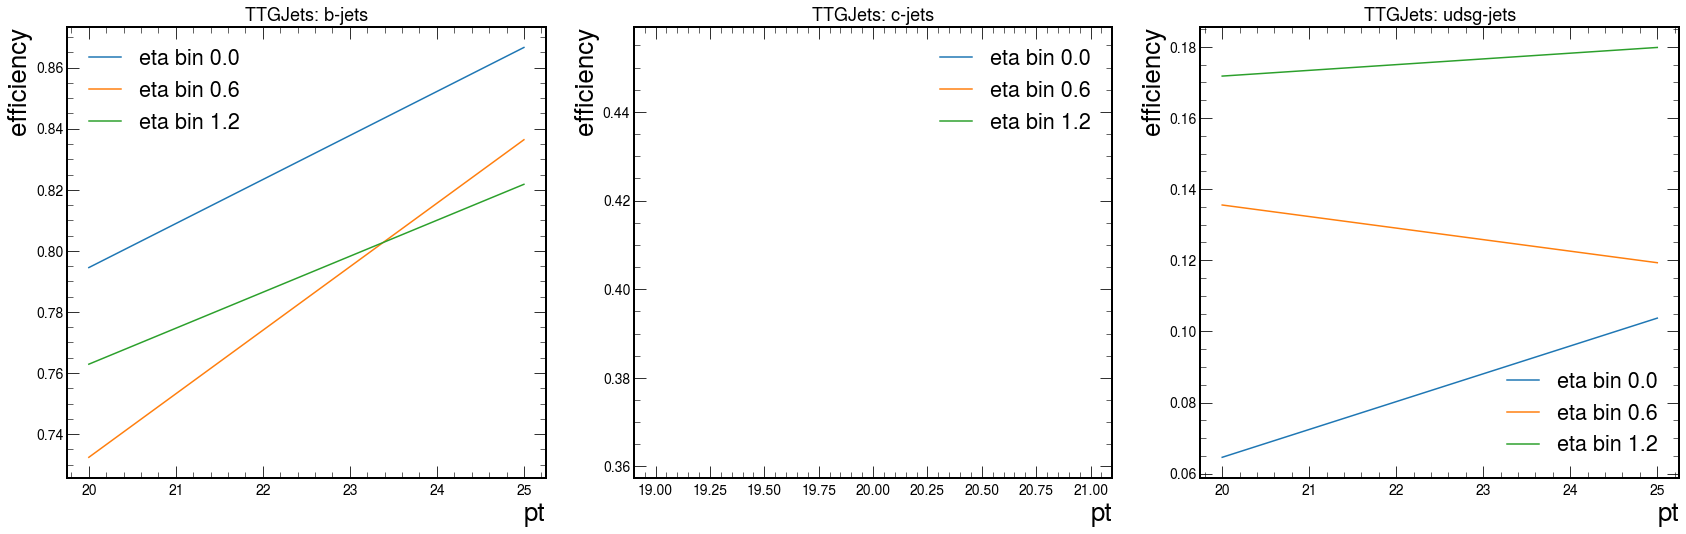

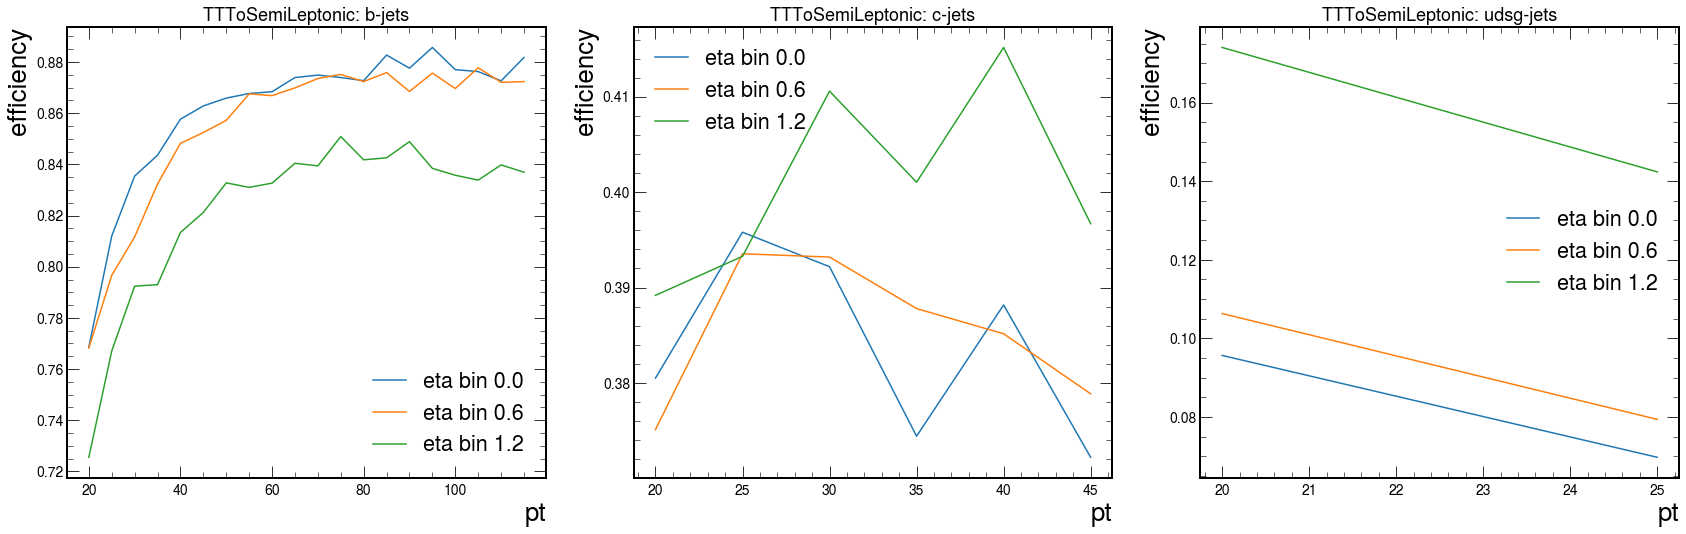

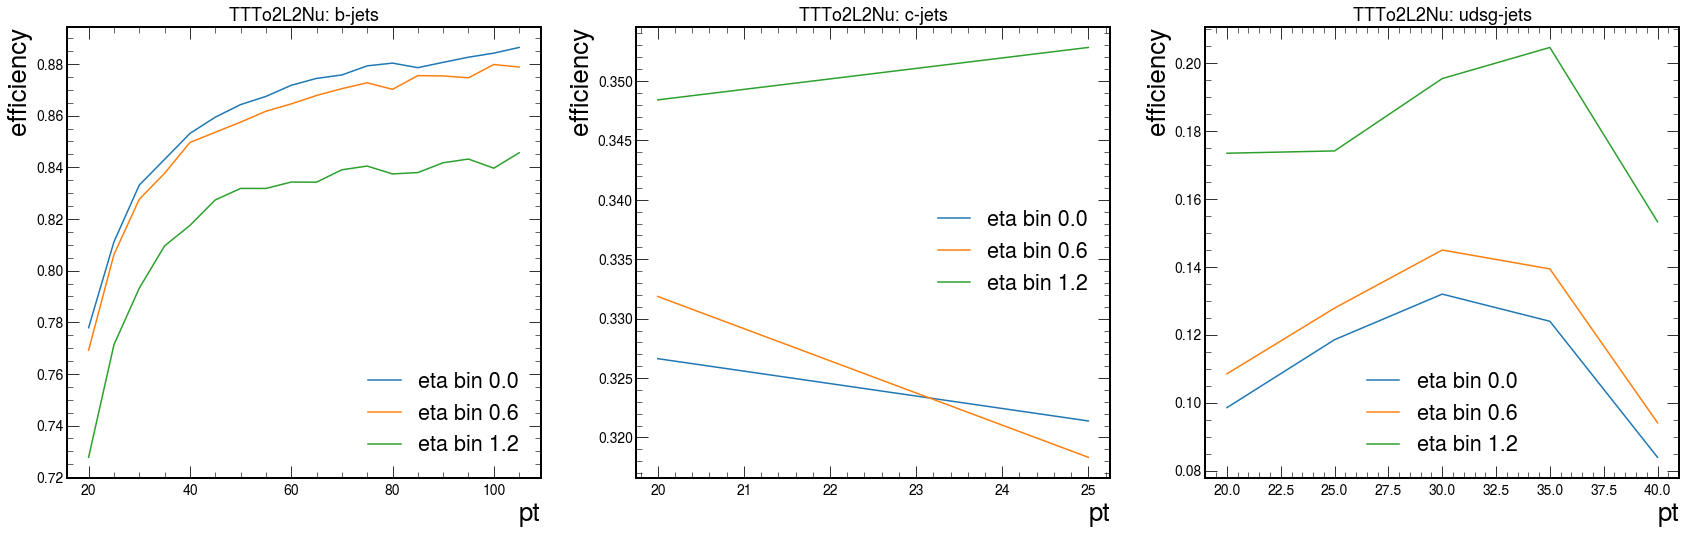

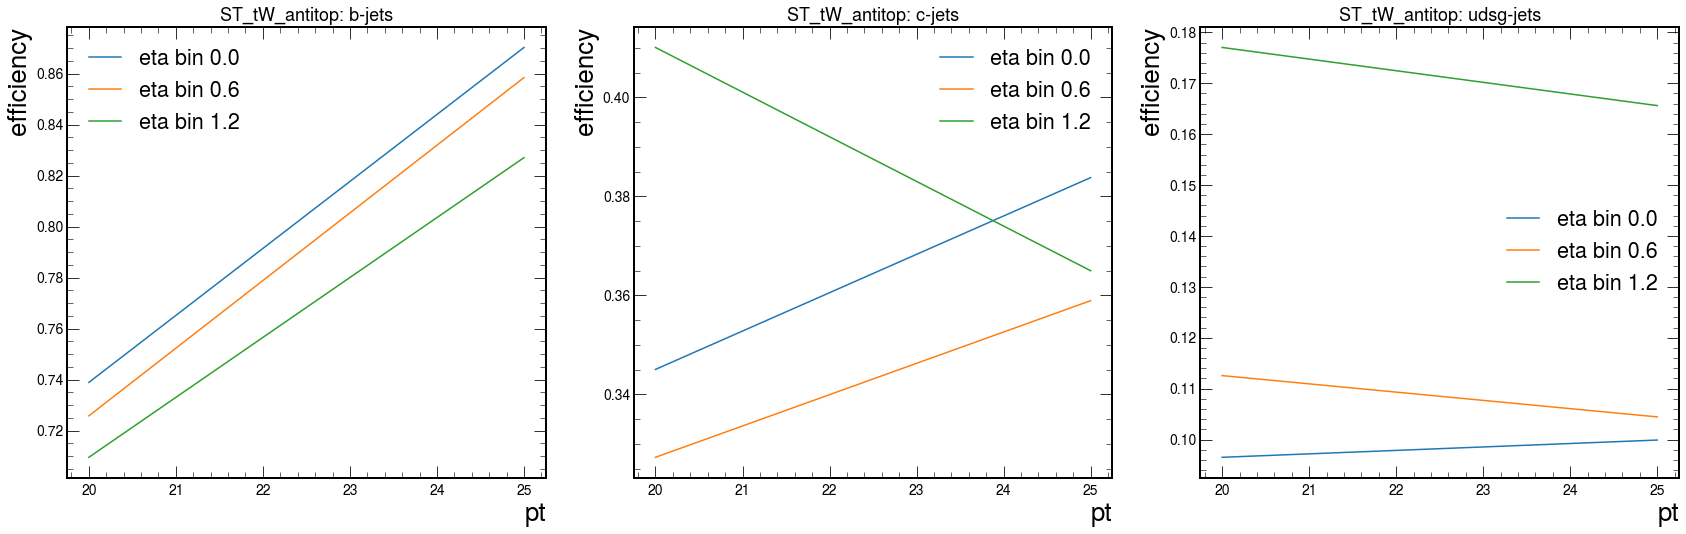

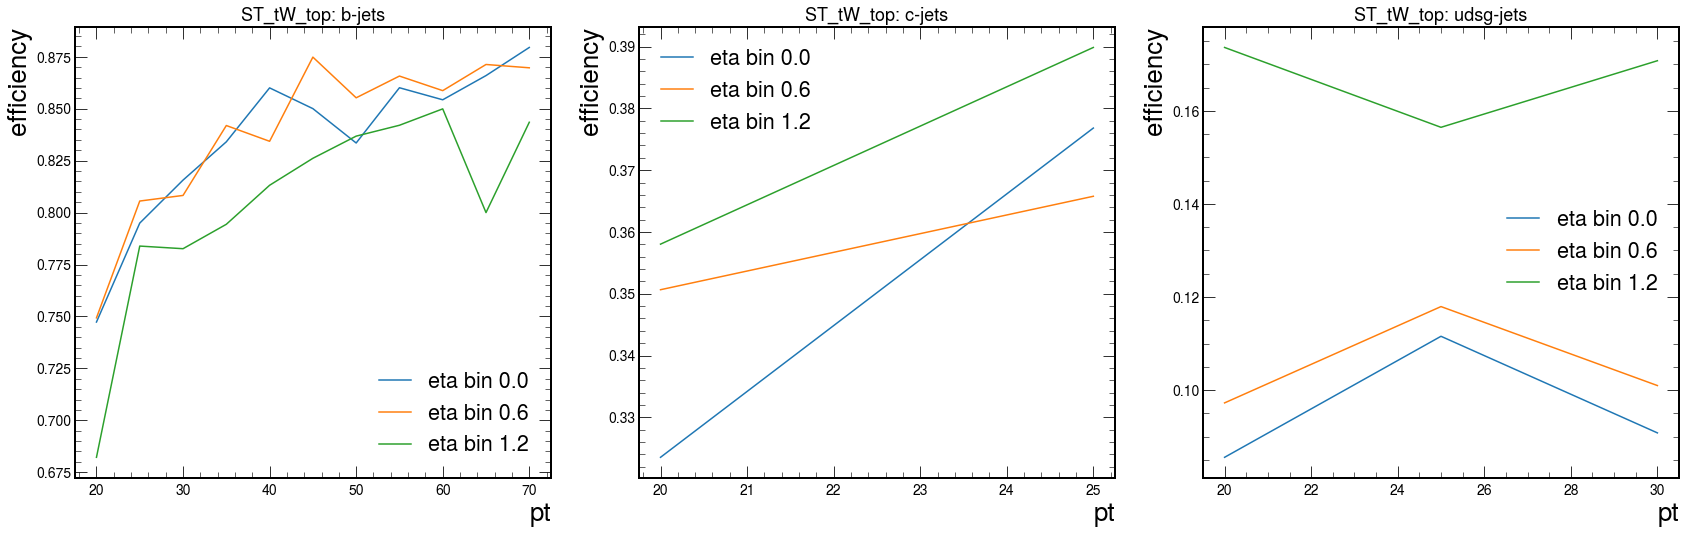

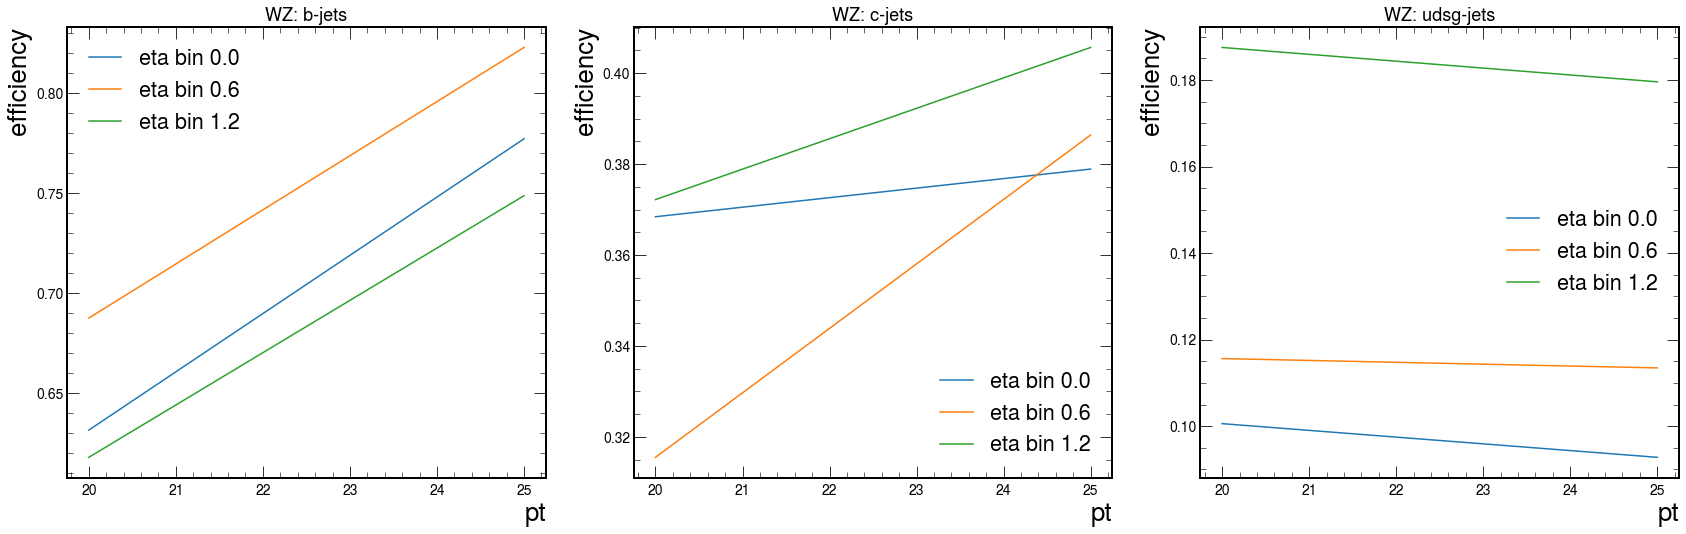

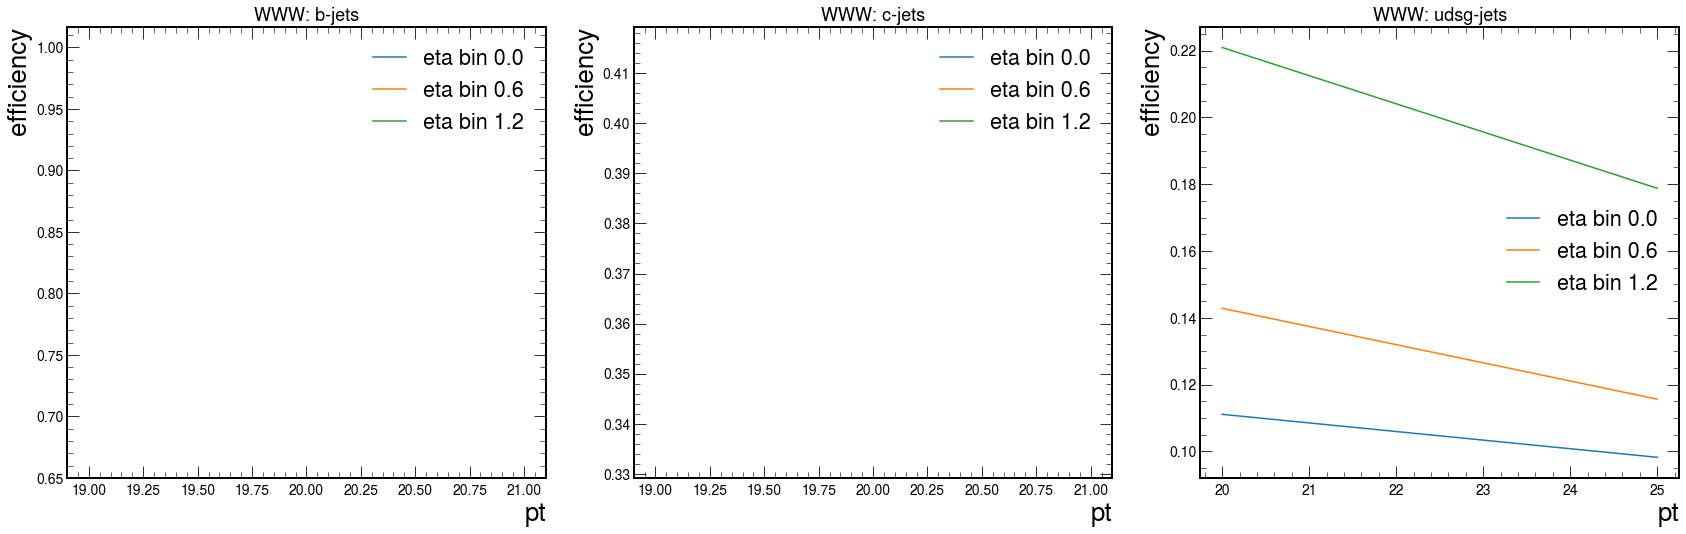

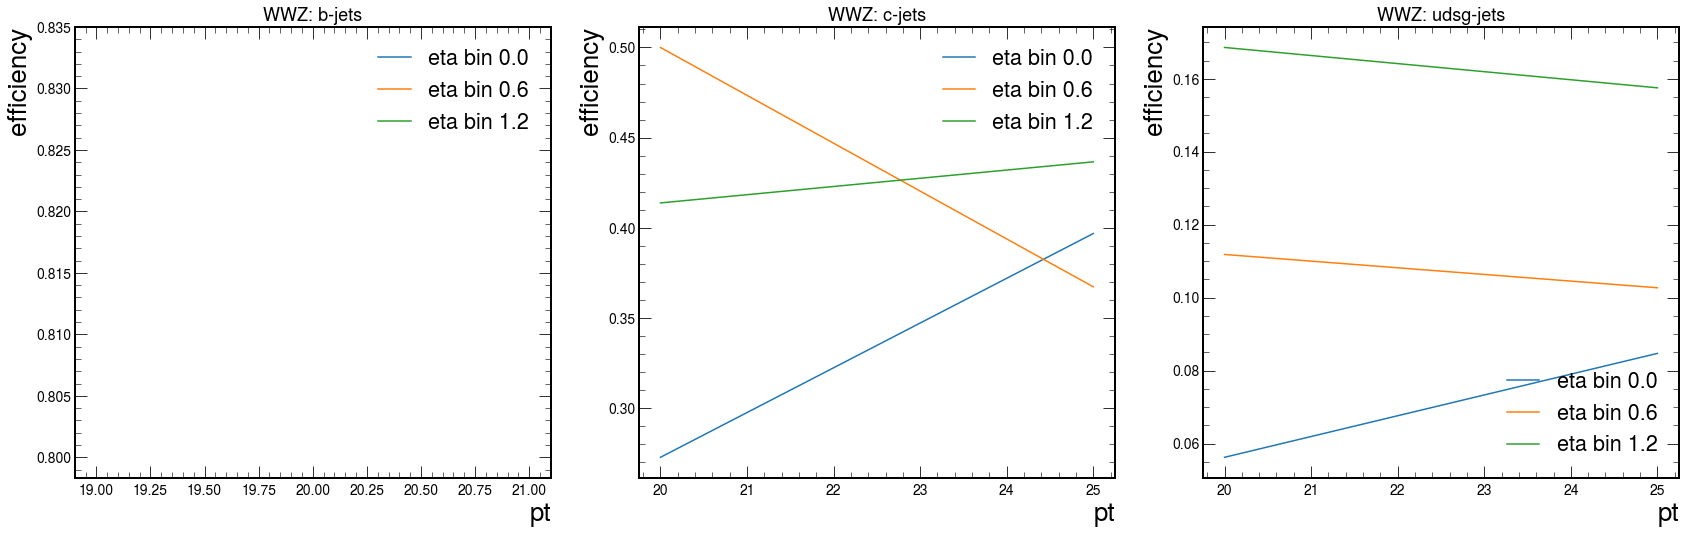

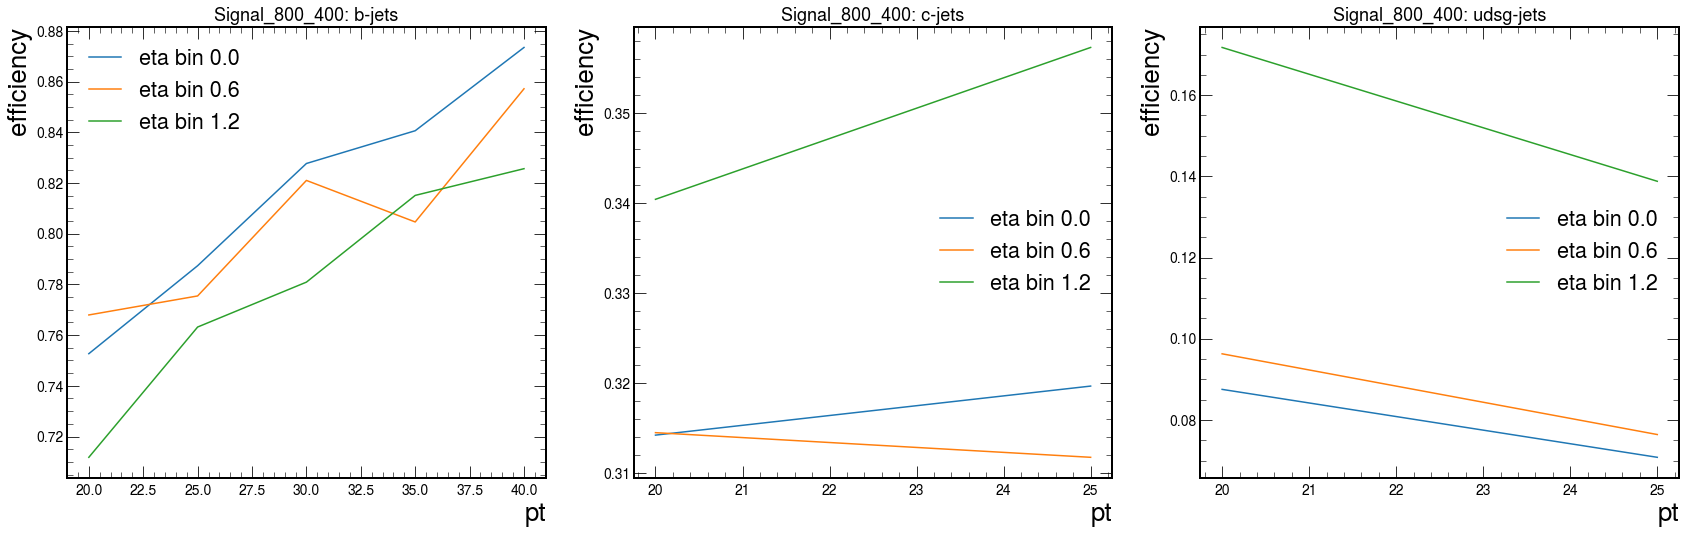

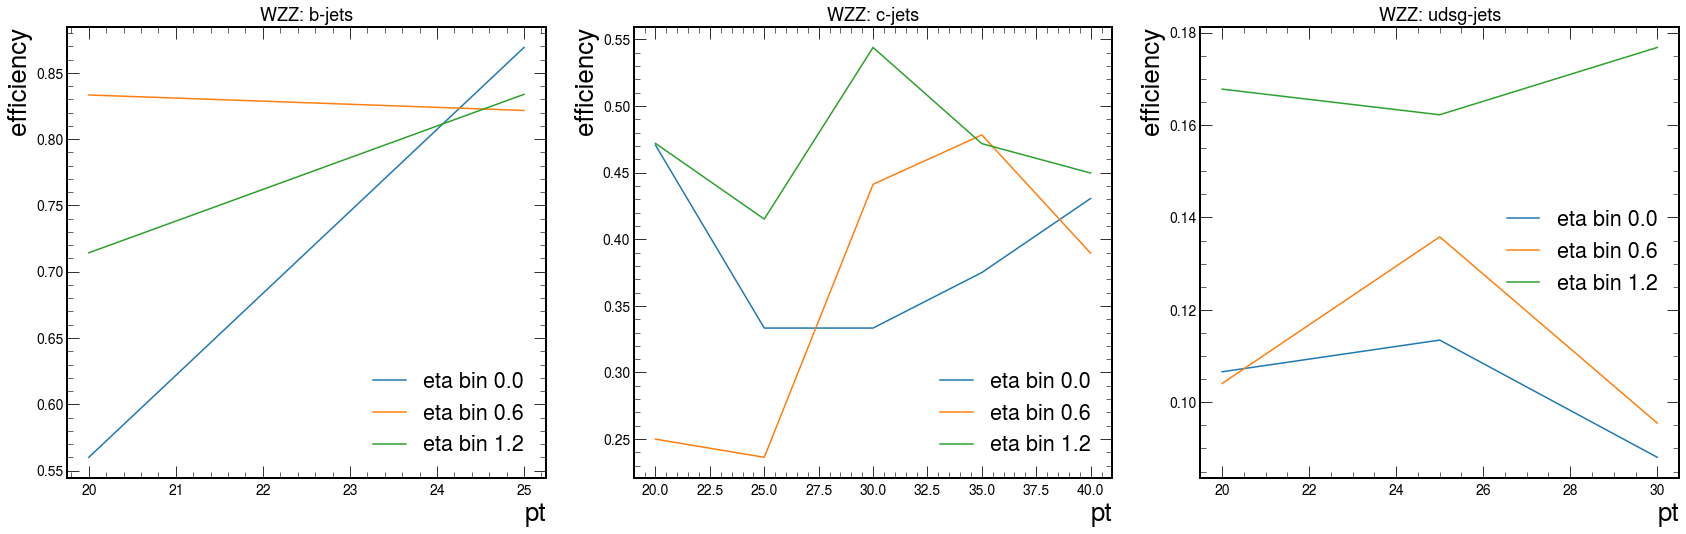

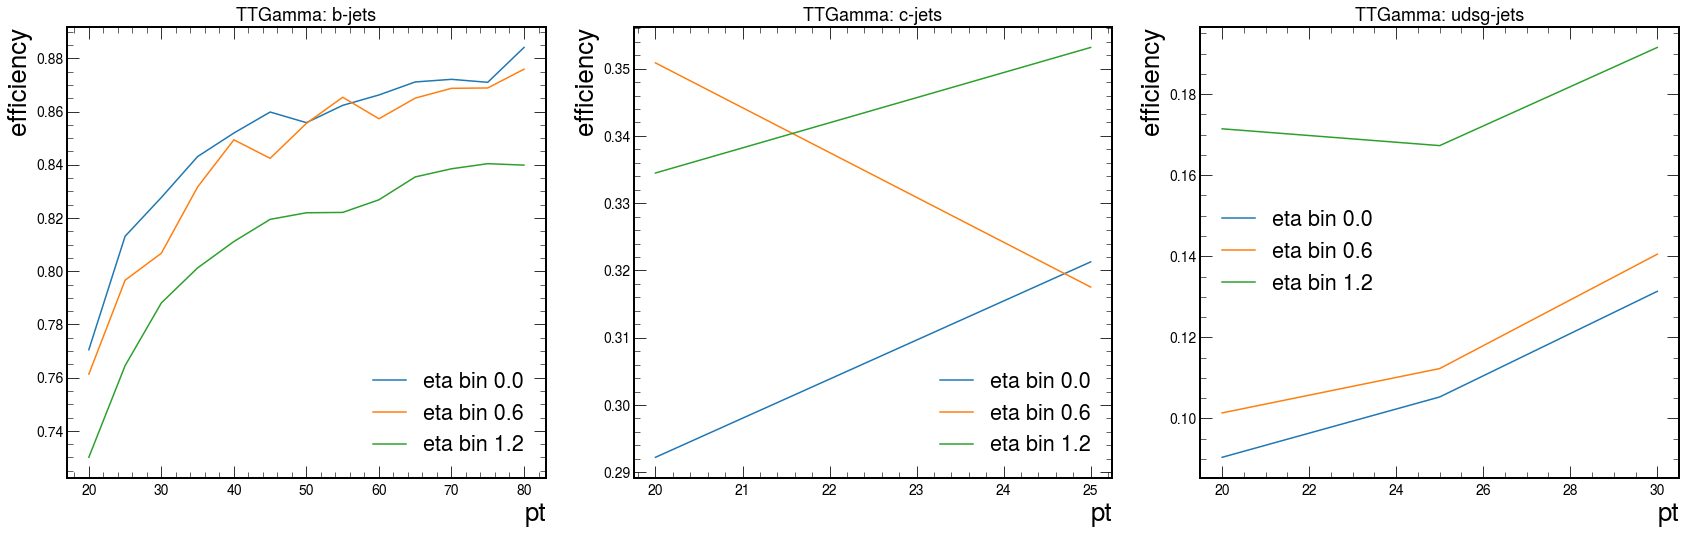

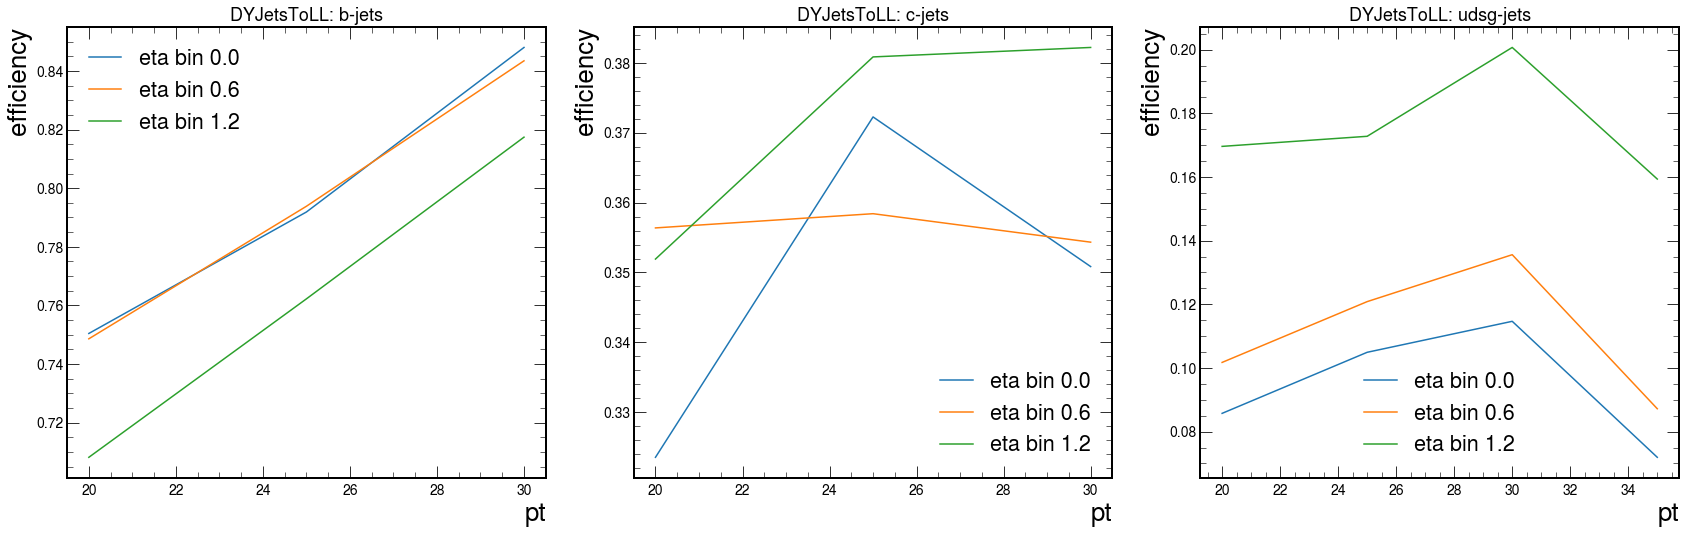

In [5]:
if os.path.isdir('./output/16postVFP') is False:
    os.makedirs('./output/16postVFP')

for dataset_name, eff_map in eff_maps.items():
    plot_fpath = os.path.join('./output/16postVFP', f'{dataset_name}_effetabin_{algo}-{working_point}.png')
    fig = plt.figure(figsize=(24,8))
    for i, hf in enumerate(eff_map.keys()):
        dt = eff_map.get(hf)
        eta_min = np.array([d.get('eta_min') for d in dt])
        pt_min = np.array([d.get('pt_min') for d in dt])
        eff = np.array([d.get('eff') for d in dt])

        shape = (int(pt_min.size/3), 3)
        eta_min = eta_min.reshape(shape)[0]
        pt_min = pt_min.reshape(shape)[:,0]
        eff = eff.reshape(shape)

        ax = fig.add_subplot(1,3,i+1)
        for i, eta in enumerate(eta_min):
            ax.plot(pt_min, eff[:,i], label=f'eta bin {eta}')

        ax.set_title(f'{dataset_name}: {hf}-jets', fontsize=18)
        ax.set_xlabel('pt')
        ax.set_ylabel('efficiency')
        ax.legend()

    fig.tight_layout()
    plt.savefig(plot_fpath, dpi=500)
    plt.show()